# MNIST Tensorflow Neural Network

This is an example of a simple fully connected neural network using the MNIST dataset.<br>
The __[MNIST dataset](http://yann.lecun.com/exdb/mnist/)__ consists of 70000 labelled pictures of hand-written digits (from 0-9). The pictures have a size of 28 by 28 pixels.<br><br>
The architecture will be simple as the goal is to reach a high accuracy within 5 minutes of training. Better accuracy could be obtained using a deeper network (more hidden layers) or using a different architecture such as a convolutional network.
The architecture of the network will be a simple fully connected network consisisting of 3 hidden layers and one output layer. The neural network will be trained to predict the digit on the picture.<br>

Let's first import the different libraries used.

In [2]:
from preprocessed_mnist import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
from IPython.display import clear_output

## The dataset
The data is split into the following:<br>
50000 pictures for the training set<br>
10000 pictures for the validation set<br>
10000 pictures for the test set<br><br>
Let's load and split the data set:

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

10256384/11490434 [=========================>....] - ETA: 0s

Some examples of the pictures of the dataset are displayed below. It can be seen that the pictures are fairly low resolution. This will make the training faster are there will less parameters in the network.

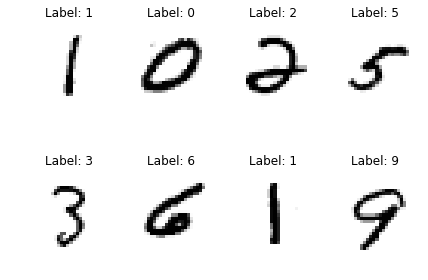

In [4]:
cols = 4
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(X_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_train[random_index, :], cmap="Greys")
        true_label = y_train[random_index]
        ax.set_title("Label: {}".format(true_label))
plt.show()

## Architecture of the network

Each layer consits of linear transformation and a non-linear activation function.<br>
The linear transformation is given by:<br>
\begin{align}
\ \textbf{z} & = \textbf{W}.\textbf{x} + \textbf{b}  \\
\end{align}
<br>
Where __W__ represents the weights of each unit, __x__ the inputs of the layer and __b__ the bias term of a layer.<br><br>
The network consists of 3 hidden layers with a ReLU activation function and one ouput layer with a softmax activation function. 

The weights are initialized using the __[He initializer](http://arxiv.org/abs/1502.01852)__, that is to say there assigned random values from a normal distribution with mean 0 and variance $\frac{2}{n_{in}}$ where $n_{in}$ is the number of input units. The biases are initialized with zeros.


### The ReLU activation function

The activation (non-linear) function used for the hidden layers is the ReLU (rectified linear unit) function. The ReLU function is defined as:<br><br>
\begin{align}
\ \sigma(x) & = max(0,x)  \\
\end{align}

An activation function should be differentiable in order to perform backpropagation. As the ReLU fucntion is not continuous, it is not differentiable at x=0, however this not a problem. The derivative of the of the ReLU function is:<br><br>
\begin{align}
\ \sigma'(x) & = 1 \  \ if \ \ x>0  \\
\ and \\
\ \sigma'(x) & = 0 \  \ if \ \ x>0  \\
\end{align}
Below is a graph of the ReLU function:

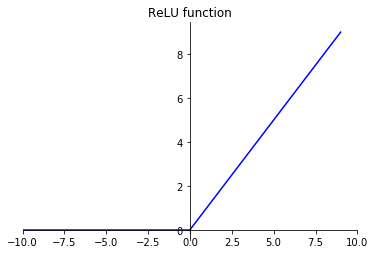

In [5]:
x1 = np.arange(0,10)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.title('ReLU function')
plt.xlim(-10,10)
plt.plot(x1, c='b')
x2 = np.arange(-10,1)
z= np.zeros(11)
plt.plot(x2,z, c='b')


### The softmax activation function

The output layer consists of ten units. Each unit represents a digit and returns the corresponding probability that the picture is a certain digit. The activation function therefore needs to be normalized so that the sum of the outputs is equal to 1.<br>
The softmax function is defined as:<br><br>

\begin{align}
\ \sigma(z)_{j} & = \frac{e^{z_{j}}}{\sum_{k=1}^ne^{z_{k}}}  \\
\end{align}

The softmax is differentiable and it is derivative is fairly simple as it involves the exponential function. It can be shown that the derivative is given by:

\begin{align}
\ \frac{\partial \sigma(z_{i})}{\partial z_{j}} & = \sigma(z_{i}) (\delta_{ij} - \sigma(z_{j}) ) \\
\end{align}

The derivation of this formula is left to the reader or it can be found __[here](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/)__.


### Loss function
To measure of how well the network is predicting the class of each picture through the training will be using the cross entropy function. The function is used for classes that are mutually exclusive and is easily differentiable given the softmax function which allows for backpropagation. 
More information on the loss function used can be found __[here](https://deepnotes.io/softmax-crossentropy)__ and __[here](https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits)__.

### The optimizer
The optimizer used is the __[RMSProp optimizer](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)__. The idea behind this optimizer is to speed up gradient descent by forcing the gradient to be in the same direction as the adjacent batches, this is achieved by dividing the gradient by a running	average of its recent magnitude. 

### Mini-batch

Mini-batch gradient descent is a method that allows for the weights and biases to be updated after looking at a portion of the training set. This allows for a comprimise between regular update and computational efficiency.
More information can be found __[here](https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits)__.
Unfortunately Tensorflow does not have (yet?) an implementation for mini-batch, below is the function that will be used for mini-batch.

In [6]:
#Mini batch function
#From https://stackoverflow.com/questions/40994583/how-to-implement-tensorflows-next-batch-for-own-data
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

## The code

In [133]:
#Start the tensorflow session
s = tf.InteractiveSession()

In [134]:
#Hyper parameters
learning_rate = 0.0001
training_epochs = 30
beta = 0.001    #L2 regularizer parameter
batch_size = 32  #mini batch size
n_input = 784 # MNIST data input size (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
n_hidden_1 = 200 # 1st layer number of neurons
n_hidden_2 = 100 # 2nd layer number of neurons
n_hidden_3 = 50 # 3rd layer number of neurons

#Variables to keep track of accuracy and loss at different epochs in order to create graphs
train_log = []
val_log = []
epoch_log = []
train_loss_log = []
val_loss_log = []

In [135]:
# Define placeholders
x = tf.placeholder(dtype = tf.float32, shape = [None, 28,28])
#the pictures are flatten changed from a 28 by 28 array to a 784 array so that can be fed into the input layer
x_flatten = tf.contrib.layers.flatten(x)

y = tf.placeholder(dtype = tf.int32, shape = [None,])
#The labels y are transformed into one hot vectors so that they can be compared to the softmax outputs
y_one_hot = tf.one_hot(y, n_classes)

In [136]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev= tf.sqrt(2/n_input))),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=tf.sqrt(2/n_hidden_1))),
    'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3], stddev=tf.sqrt(2/n_hidden_2))),
    'out': tf.Variable(tf.random_normal([n_hidden_3, n_classes], stddev=tf.sqrt(2/n_hidden_3)))
}
biases = {
    'b1': tf.Variable(tf.zeros([n_hidden_1])),
    'b2': tf.Variable(tf.zeros([n_hidden_2])),
    'b3': tf.Variable(tf.zeros([n_hidden_3])),
    'out': tf.Variable(tf.zeros([n_classes]))
}

In [137]:
# Create model
def multilayer_perceptron(x):
    # Hidden fully connected layer with  neurons
    layer_1 = tf.add(tf.matmul(x_flatten, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)   
    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)  
    out_layer = tf.matmul(layer_3, weights['out']) + biases['out']
    return out_layer

In [138]:
# Construct model
logits = multilayer_perceptron(x)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y))
#Loss function with L2 Regularization with beta=0.01
regularizers = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2']) + tf.nn.l2_loss(weights['h3']) 
loss_op = tf.reduce_mean(loss_op + beta * regularizers)
#Define the optimizer
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# Initializing the variables
init = tf.global_variables_initializer()

Epoch 28 summary:

Training 1oss: 0.1168
Training accuracy: 0.992

Validation 1oss: 0.1601
Validation accuracy: 0.977


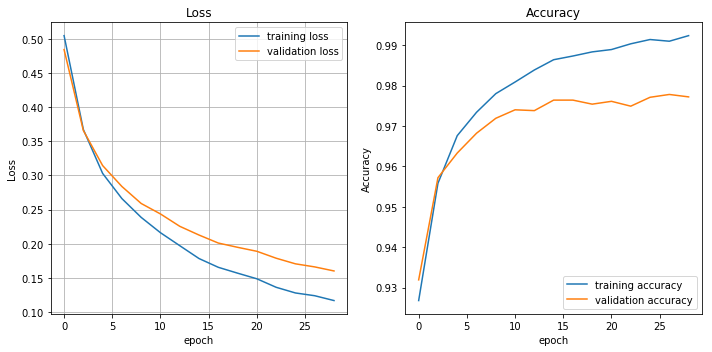

Test accuracy: 0.976


In [139]:
# Start the tensorflow session
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        for batch in range (int(len(y_train)/batch_size)):
            X_batch, y_batch = next_batch(batch_size, X_train, y_train)
            sess.run([train_op, loss_op], feed_dict={x: X_batch, y: y_batch})         
        
        if (epoch % 2 == 0):
            _, l = sess.run([train_op, loss_op], feed_dict={x: X_train, y: y_train})
            clear_output()
            predictions = tf.nn.softmax(logits)
            correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y_one_hot, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            training_accuracy = accuracy.eval(feed_dict={x: X_train, y: y_train})
            validation_accuracy, validation_loss = sess.run([accuracy, loss_op], feed_dict={x: X_val, y: y_val})
            
            print('Epoch {} summary:\n'.format(epoch))
            print('Training 1oss: {:.4f}'.format(l))
            print('Training accuracy: {:.3f}\n'.format(training_accuracy))
            print('Validation 1oss: {:.4f}'.format(validation_loss))
            print('Validation accuracy: {:.3f}'.format(validation_accuracy))
            
            #add accuracies and losses to arrays to be able to plot
            train_log.append(training_accuracy)
            val_log.append(validation_accuracy)
            val_loss_log.append(validation_loss)
            train_loss_log.append(l)
            epoch_log.append(epoch)
            
            fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
            #Accuracy graph
            ax = axes[0]
            ax.plot(epoch_log, train_loss_log, label='training loss')
            ax.plot(epoch_log, val_loss_log, label='validation loss')
            ax.legend(loc='best') 
            ax.set_title('Loss')
            ax.set_xlabel('epoch')
            ax.set_ylabel('Loss')   
            ax.grid()
            #Loss graph
            ax = axes[1]
            ax.plot(epoch_log,train_log,label='training accuracy')
            ax.plot(epoch_log,val_log,label='validation accuracy')
            ax.legend(loc=4)
            ax.set_title('Accuracy')
            ax.set_xlabel('epoch')
            ax.set_ylabel('Accuracy') 
            plt.tight_layout()
            plt.show()

    
    # Test model
    pred = tf.nn.softmax(logits)  # Apply softmax to logits
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y_one_hot, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print('Test accuracy: {:.3f}'.format(accuracy.eval(feed_dict={x: X_test, y: y_test})))
    #Stores predictions to be displayed later
    prediction = tf.argmax(pred, 1)
    predictions = prediction.eval(feed_dict={x: X_test}, session = sess)
    #Stores the probabilities of 
    probabilities = pred.eval(feed_dict={x: X_test}, session = sess)

### Results

The accuracy on the test sample (unseen during training) is over 97.5%, considering that the model took about 5 minutes to train this is quite good but it is far from the state of the art architectures.
Looking at the graphs of the loss and the accuracy, it can be seen that there is a gap between the training and the validation. In particular the training accuracy reaches values that are around to 99% while the validation is around 97%. This shows that the model is overfitting. To decrease the overfitting of the model the beta value of the L2 regularizer can be increased. The model will take longer to converge but will not overfit as much.

Let's take a look at a sample of pictures and compare the predictions to the true label. The score represents the probability that the network assigned to this digits (the output of the softmax function), it can be interpreted as the level of confidence 

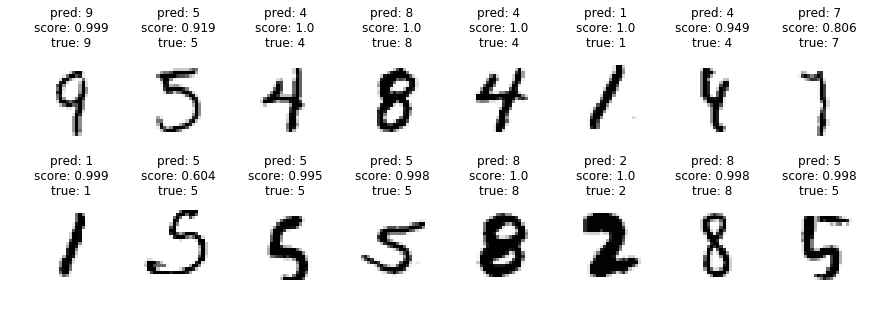

In [140]:
# inspect random predictions 
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_test[random_index, :], cmap="Greys")
        pred_label = predictions[random_index]
        pred_proba = np.amax(probabilities, axis=1)[random_index]
        true_label = y_test[random_index]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

#### Inspecting the wrong predictions

To understand the model better, it is important to consider where it fails to make correct predictions. Below are some expamples of wrong predictions.

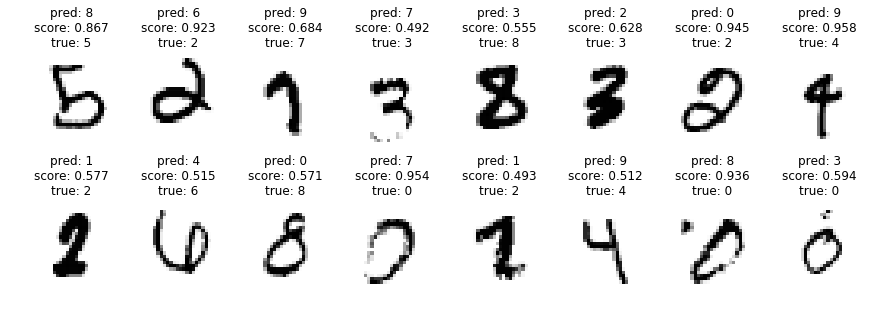

In [118]:
# inspect random wrong  predictions 

#Stores the indices for the wrong predictions
indices_of_wrong = []
for i in range(len(predictions)):
    if predictions[i]!= y_test[i]:
        indices_of_wrong.append(i)


cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(indices_of_wrong))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_test[indices_of_wrong[random_index], :], cmap="Greys")
        pred_label = predictions[indices_of_wrong[random_index]]
        pred_proba = np.amax(probabilities, axis=1)[indices_of_wrong[random_index]]
        true_label = y_test[indices_of_wrong[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()